Customer Segmentation
Loyalty program

### Workflow:
 1. [Data Preprocessing](#Data-Preprocessing)
  -  <font color = green>Importing necessary libraries
  - Reading data
  - Exploring the data
  - Data cleaning
  - Merging datasets
 2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    -  <font color = green>Univariate Analysis
    - Contributions by the top customer
    - Bivariate analysis
    - Multivariate analysis
    - Top 10 customers-analysis </font>
 3. [RFM Analysis](#RFM-Analysis)
    - <font color = green> Generating R,F and M values
    - Creating R,F and M labels
    - Defining R,F and M label functions
    - Final Inference R,F and M labels <font>
 4. [Clustering](#Clustering)
    - <font color = green>Pre-processing
    - Elbow method to choose optimum clusters
    - Clustering
    - Silhouette score
    - Inference from clusters</font>

## Data preprocessing
#### <font color = green>Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt

import seaborn as sns

from sklearn import preprocessing
from IPython.display import Image

from sklearn.cluster import KMeans

#### <font color = green>Reading data

In [2]:
#Reading the Customer master using pandas
cus=pd.read_csv('customer.csv')

#Reading the store master using pandas
store=pd.read_excel('Store.xlsx')

##Reading the transaction using pandas
trans=pd.read_csv('trans.csv')

#### <font color=green>Exploring the data

In [3]:
#Shapes of the data frames
print("Customer Master data set has {} rows and {} columns ".format(cus.shape[0],cus.shape[1]))
print("Store info data set has {} rows and {} columns ".format(store.shape[0],store.shape[1]))
print("Transaction data set has {} rows and {} columns ".format(trans.shape[0],trans.shape[1]))

Customer Master data set has 50018 rows and 6 columns 
Store info data set has 559 rows and 5 columns 
Transaction data set has 358088 rows and 6 columns 


In [4]:
#dropping the empty customer name column

print(cus.info())
cus=cus.drop('new_customer_name (populate distinct names from any open dataset)',axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50018 entries, 0 to 50017
Data columns (total 6 columns):
customer_id                                                          50018 non-null int64
new_customer_name (populate distinct names from any open dataset)    0 non-null float64
created_at                                                           50018 non-null object
gender                                                               24717 non-null object
state                                                                42834 non-null object
tier                                                                 50018 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 2.3+ MB
None


In [5]:
store.info()
print(trans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
store_name             559 non-null object
store_code             559 non-null object
store_location         559 non-null object
store_category         406 non-null object
store_PriceCategory    559 non-null object
dtypes: object(5)
memory usage: 21.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358088 entries, 0 to 358087
Data columns (total 6 columns):
billing_timestamp    358088 non-null object
transaction_type     358088 non-null object
amount               356180 non-null float64
points               358088 non-null float64
store_code           356179 non-null object
customer_mobile      358088 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.4+ MB
None


#### <font color = green>Data cleaning

Male      13649
Female    11063
Other         5
Name: gender, dtype: int64


<BarContainer object of 3 artists>

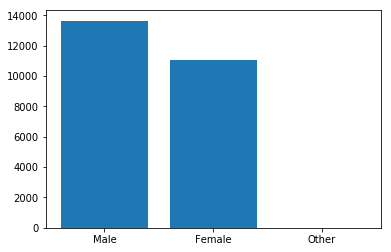

In [6]:
print(cus['gender'].value_counts())
plt.bar(cus['gender'].value_counts().index,cus['gender'].value_counts().values)

In [7]:
print(cus['gender'].isnull().sum())
#There are 25301 null values which contributes to 50% of the total values
#Imputing the gender with mode or other ways will not be a meaningful imputation
#We'd impute the Unknown gender with "Unknown"

#filling the customer gender unknown values
cus['gender']=cus['gender'].fillna('Unknown')
cus['gender'].isnull().sum()

25301


0

In [8]:
#State column has 15% of null values
(1-cus.isnull().sum()['state']/cus.shape[0])*100 #85% values are filled for state

85.63717061857731

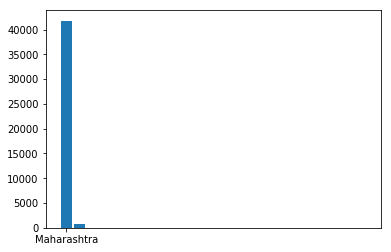

In [9]:

plt.bar(cus['state'].value_counts().index,cus['state'].value_counts().values)
plt.xticks(cus['state'].mode()[0])
plt.show()

In [10]:
cus['state']=cus['state'].fillna(cus['state'].mode()[0]) #imputing with mode

cus.info() #customer data is cleaned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50018 entries, 0 to 50017
Data columns (total 5 columns):
customer_id    50018 non-null int64
created_at     50018 non-null object
gender         50018 non-null object
state          50018 non-null object
tier           50018 non-null object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [11]:
#We have customer ID as customer mobile in transaction data
trans=trans.rename(columns={'customer_mobile':'customer_id'})

#Checking for identical customer IDs
trans['customer_id'].isin(cus['customer_id']).value_counts()

True    358088
Name: customer_id, dtype: int64

In [12]:
#Compressing the transaction dataset reducing to only purchase of transaction type
trans=trans[trans['transaction_type']=='purchase']

trans.index

Int64Index([   845,    846,    847,    848,    849,    850,    851,    852,
               853,    854,
            ...
            358078, 358079, 358080, 358081, 358082, 358083, 358084, 358085,
            358086, 358087],
           dtype='int64', length=356179)

In [13]:
#Resetting Index
trans=trans.reset_index(drop=True)

trans.shape

(356179, 6)

In [14]:
#No of unique customer IDs
len(trans['customer_id'].unique())

13177

In [15]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356179 entries, 0 to 356178
Data columns (total 6 columns):
billing_timestamp    356179 non-null object
transaction_type     356179 non-null object
amount               356179 non-null float64
points               356179 non-null float64
store_code           356179 non-null object
customer_id          356179 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.3+ MB


In [16]:
print(store.info())
store['store_category']=store['store_category'].fillna('Unknown')
store.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
store_name             559 non-null object
store_code             559 non-null object
store_location         559 non-null object
store_category         406 non-null object
store_PriceCategory    559 non-null object
dtypes: object(5)
memory usage: 21.9+ KB
None


store_name             0
store_code             0
store_location         0
store_category         0
store_PriceCategory    0
dtype: int64

#### <font color = green>Merging datasets

Merging the Customer and store data with Transaction Data

In [17]:
#merging customer and trans using left join
trans_merge = pd.merge(trans,
                     cus,
                     on='customer_id', 
                     how='left')
# merging store data using left join
df = pd.merge(trans_merge,
                     store,
                     on='store_code', 
                     how='left')

print(df.shape)

df.head()

(356179, 14)


,billing_timestamp,transaction_type,amount,points,store_code,customer_id,created_at,gender,state,tier,store_name,store_location,store_category,store_PriceCategory
0,2014-10-20 22:38:00 +0530,purchase,3200.0,32.0,IMA00001,256622493374,2019-03-19 15:37:22 +0530,Male,Maharashtra,Blue Member,Sprinkles,Diamond Mall,"Accessories,Jewellery,Women's Fashion",Premium
1,2014-10-20 22:38:00 +0530,purchase,2000.0,20.0,IMM00003,212411292920,2019-03-19 15:37:24 +0530,Male,Kerala,Blue Member,Das Shoes,Emerald Mall,"Accessories,Sports & Fitness,Women's Fashion,M...",Premium
2,2014-10-20 22:38:00 +0530,purchase,1000.0,10.0,NA-IMA0048,256583467853,2019-03-19 15:37:23 +0530,Male,Maharashtra,Blue Member,Gameon!,Diamond Mall,"Electronics,Entertainment & Leisure",Premium
3,2014-10-20 22:38:00 +0530,purchase,5000.0,50.0,IMA00007,256583467853,2019-03-19 15:37:23 +0530,Male,Maharashtra,Blue Member,Das Shoes,Diamond Mall,"Accessories,Sports & Fitness,Women's Fashion,M...",Premium
4,2014-10-20 22:38:00 +0530,purchase,80000.0,800.0,NA-IMA0014,256583467853,2019-03-19 15:37:23 +0530,Male,Maharashtra,Blue Member,Cuffs,Diamond Mall,Men's Fashion,Premium


In [18]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356179 entries, 0 to 356178
Data columns (total 14 columns):
billing_timestamp      356179 non-null object
transaction_type       356179 non-null object
amount                 356179 non-null float64
points                 356179 non-null float64
store_code             356179 non-null object
customer_id            356179 non-null int64
created_at             356179 non-null object
gender                 356179 non-null object
state                  356179 non-null object
tier                   356179 non-null object
store_name             350611 non-null object
store_location         350611 non-null object
store_category         350611 non-null object
store_PriceCategory    350611 non-null object
dtypes: float64(2), int64(1), object(11)
memory usage: 40.8+ MB


In [19]:
#Changing Date columns to date object from string object

df['created_at']=pd.to_datetime(df['created_at'])

df['billing_timestamp']=pd.to_datetime(df['billing_timestamp'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356179 entries, 0 to 356178
Data columns (total 14 columns):
billing_timestamp      356179 non-null datetime64[ns, pytz.FixedOffset(330)]
transaction_type       356179 non-null object
amount                 356179 non-null float64
points                 356179 non-null float64
store_code             356179 non-null object
customer_id            356179 non-null int64
created_at             356179 non-null datetime64[ns, pytz.FixedOffset(330)]
gender                 356179 non-null object
state                  356179 non-null object
tier                   356179 non-null object
store_name             350611 non-null object
store_location         350611 non-null object
store_category         350611 non-null object
store_PriceCategory    350611 non-null object
dtypes: datetime64[ns, pytz.FixedOffset(330)](2), float64(2), int64(1), object(9)
memory usage: 40.8+ MB


In [20]:
df[df['store_name'].isnull()==True]['store_code'].value_counts() #Store code's value missing

S0001    4946
S0002     622
Name: store_code, dtype: int64

In [21]:
df=df.fillna('Unknown') #Filling the Unknown store values with 'Unknown' tag

df.isnull().sum()

billing_timestamp      0
transaction_type       0
amount                 0
points                 0
store_code             0
customer_id            0
created_at             0
gender                 0
state                  0
tier                   0
store_name             0
store_location         0
store_category         0
store_PriceCategory    0
dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356179 entries, 0 to 356178
Data columns (total 14 columns):
billing_timestamp      356179 non-null datetime64[ns, pytz.FixedOffset(330)]
transaction_type       356179 non-null object
amount                 356179 non-null float64
points                 356179 non-null float64
store_code             356179 non-null object
customer_id            356179 non-null int64
created_at             356179 non-null datetime64[ns, pytz.FixedOffset(330)]
gender                 356179 non-null object
state                  356179 non-null object
tier                   356179 non-null object
store_name             356179 non-null object
store_location         356179 non-null object
store_category         356179 non-null object
store_PriceCategory    356179 non-null object
dtypes: datetime64[ns, pytz.FixedOffset(330)](2), float64(2), int64(1), object(9)
memory usage: 40.8+ MB


As we know all the type of transaction is 'purchase',removing transaction type column from the df

In [23]:
#Remove duplicates from the dataframe
df=df.drop_duplicates()

df=df.drop('transaction_type',axis=1)
#changing customer_id column to object type
df['customer_id']=df['customer_id'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348509 entries, 0 to 356178
Data columns (total 13 columns):
billing_timestamp      348509 non-null datetime64[ns, pytz.FixedOffset(330)]
amount                 348509 non-null float64
points                 348509 non-null float64
store_code             348509 non-null object
customer_id            348509 non-null object
created_at             348509 non-null datetime64[ns, pytz.FixedOffset(330)]
gender                 348509 non-null object
state                  348509 non-null object
tier                   348509 non-null object
store_name             348509 non-null object
store_location         348509 non-null object
store_category         348509 non-null object
store_PriceCategory    348509 non-null object
dtypes: datetime64[ns, pytz.FixedOffset(330)](2), float64(2), object(9)
memory usage: 37.2+ MB


### <font color='green'> Final data frame

In [24]:
df.head()

,billing_timestamp,amount,points,store_code,customer_id,created_at,gender,state,tier,store_name,store_location,store_category,store_PriceCategory
0,2014-10-20 22:38:00+05:30,3200.0,32.0,IMA00001,256622493374,2019-03-19 15:37:22+05:30,Male,Maharashtra,Blue Member,Sprinkles,Diamond Mall,"Accessories,Jewellery,Women's Fashion",Premium
1,2014-10-20 22:38:00+05:30,2000.0,20.0,IMM00003,212411292920,2019-03-19 15:37:24+05:30,Male,Kerala,Blue Member,Das Shoes,Emerald Mall,"Accessories,Sports & Fitness,Women's Fashion,M...",Premium
2,2014-10-20 22:38:00+05:30,1000.0,10.0,NA-IMA0048,256583467853,2019-03-19 15:37:23+05:30,Male,Maharashtra,Blue Member,Gameon!,Diamond Mall,"Electronics,Entertainment & Leisure",Premium
3,2014-10-20 22:38:00+05:30,5000.0,50.0,IMA00007,256583467853,2019-03-19 15:37:23+05:30,Male,Maharashtra,Blue Member,Das Shoes,Diamond Mall,"Accessories,Sports & Fitness,Women's Fashion,M...",Premium
4,2014-10-20 22:38:00+05:30,80000.0,800.0,NA-IMA0014,256583467853,2019-03-19 15:37:23+05:30,Male,Maharashtra,Blue Member,Cuffs,Diamond Mall,Men's Fashion,Premium


## Exploratory Data Analysis
###  <font color = green>Univariate Analysis

In [25]:
df.describe()
#Mean of the Amount transactioned is 2961.82
#Min is 0 and Max is 1330000 {Thirteen Lakhs Thirty Thousand}
#75% of the values are under 2630


,amount,points
count,3.485090e+05,348509.000000
mean,2.976083e+03,32.307199
std,1.108421e+04,124.150136
min,0.000000e+00,0.000000
25%,2.780000e+02,2.920000
50%,9.650000e+02,9.990000
75%,2.642000e+03,27.990000
max,1.330000e+06,13300.000000


W can infer that most of the transactions are low valued.
High valued transactions are mostly rare.

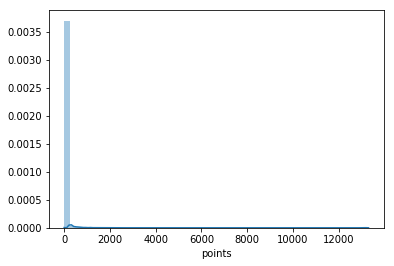

In [26]:
sns.distplot(df['points'],hist=True) #we're not getting the clear histogram,because the distribution is biasex
plt.show()

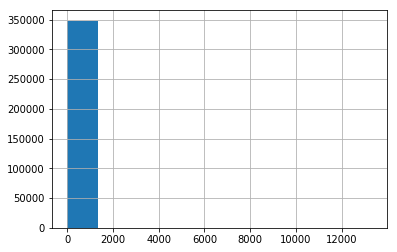

In [27]:
df['points'].hist(bins=10)

customers earn 1 point for each 100 bucks of transaction

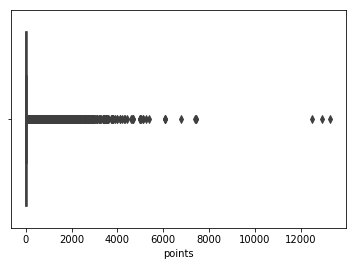

In [28]:
sns.boxplot(df['points'])

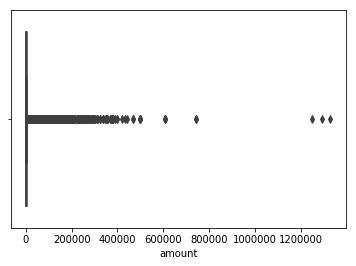

In [29]:
sns.boxplot(df['amount']) #Boxplot shows the distribution is biased towards a lower range

In [30]:
#Top contributor on transactions
df['customer_id'].value_counts()[df['customer_id'].value_counts()>1000] 


240975802340    2541
256947967425    2242
256608695427    1942
259472473372    1829
255283145507    1771
260449806289    1743
196141256469    1501
256949578418    1430
256613023470    1188
255207440548    1115
184089683800    1112
243607556755    1103
256592682127    1073
255285716438    1050
257907631184    1023
Name: customer_id, dtype: int64

In [31]:
#240975802340 is the top contributor in number of transactions
#Customer with more transactions
df[df['customer_id']=='240975802340'].head()

,billing_timestamp,amount,points,store_code,customer_id,created_at,gender,state,tier,store_name,store_location,store_category,store_PriceCategory
54947,2015-10-09 01:43:00+05:30,1203.0,12.03,IMM00183,240975802340,2019-03-19 15:48:43+05:30,Male,Maharashtra,Gold Member,Streetside Store,Emerald Mall,"Kids Fashion,Accessories,Women's Fashion,Men's...",Premium
54948,2015-10-09 01:43:00+05:30,113.0,1.13,NA-IMM0022,240975802340,2019-03-19 15:48:43+05:30,Male,Maharashtra,Gold Member,Cafe Telaviv,Emerald Mall,Unknown,Premium
56940,2015-10-29 01:44:00+05:30,280.0,2.80,IMM00094,240975802340,2019-03-19 15:48:43+05:30,Male,Maharashtra,Gold Member,Guardwell Pharma,Emerald Mall,Health & Wellness,Value
56941,2015-10-29 01:44:00+05:30,560.0,5.60,NA-IMM0022,240975802340,2019-03-19 15:48:43+05:30,Male,Maharashtra,Gold Member,Cafe Telaviv,Emerald Mall,Unknown,Premium
57509,2015-11-03 15:15:00+05:30,1294.0,12.94,IMM00061,240975802340,2019-03-19 15:48:43+05:30,Male,Maharashtra,Gold Member,Lal Mahal,Emerald Mall,Food & Beverage,Premium


### <font color='green'>Contributions by the top customer

In [32]:
print("Total amount transactioned by the top customer is",
      df[df['customer_id']=='240975802340']['amount'].sum())

print("Total point earned by the top customer is",
      df[df['customer_id']=='240975802340']['points'].sum())

print("Malls used by the top customer\n"
      ,df[df['customer_id']=='240975802340']['store_location'].value_counts())

Total amount transactioned by the top customer is 1731998.22
Total point earned by the top customer is 18463.78
Malls used by the top customer
 Emerald Mall    2541
Name: store_location, dtype: int64


In [33]:
# Store category most spent on transactions by the top customer
df[df['customer_id']=='240975802340']['store_category'].value_counts()[0:5]

Unknown                                                                                                                                      1322
Food & Beverage                                                                                                                               649
Electronics,Kids Fashion,Accessories,Grocery & Household,Home & Lifestyle,Women's Fashion,Men's Fashion,Books and Stationery,Gifts & Toys     382
Beauty & Grooming                                                                                                                              42
Kids Fashion,Accessories,Women's Fashion,Men's Fashion                                                                                         32
Name: store_category, dtype: int64

In [34]:
#Store price category where he made the more transactions
df[df['customer_id']=='240975802340']['store_PriceCategory'].value_counts()

Premium          1430
Value            1110
Super Premium       1
Name: store_PriceCategory, dtype: int64

### <font color='green'> Bivariate Analysis

In [35]:
df.corr() #There is a high co-relation between Amount and points 

,amount,points
amount,1.000000,0.965405
points,0.965405,1.000000


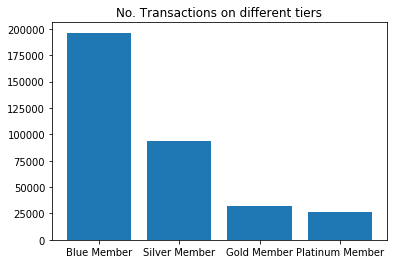

In [36]:
# No of Transactions vs different tiers
t=df['tier'].value_counts().reset_index()
t['index'].tolist()

plt.bar(t.index,t.tier)
plt.title('No. Transactions on different tiers')
plt.xticks([0,1,2,3],t['index'])
plt.show()

Text(0.5, 1.0, 'No. of Transactions vs Malls')

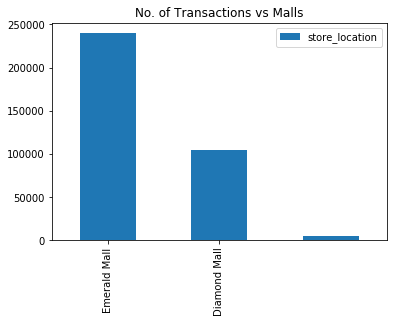

In [37]:
#Malls vs no. of transactions
df['store_location'].value_counts().reset_index().plot(kind='bar')
plt.xticks([0,1],df['store_location'].value_counts().reset_index()['index'])
plt.title('No. of Transactions vs Malls')

In [38]:
#Number of transactions vs store category
df['store_category'].value_counts() #Transactions vs Store category

Food & Beverage                                                                                                                              76678
Grocery & Household                                                                                                                          46229
Electronics,Kids Fashion,Accessories,Grocery & Household,Home & Lifestyle,Women's Fashion,Men's Fashion,Books and Stationery,Gifts & Toys    37330
Women's Fashion                                                                                                                              29570
Kids Fashion,Accessories,Women's Fashion,Men's Fashion                                                                                       27541
Women's Fashion,Men's Fashion                                                                                                                26430
Unknown                                                                                                               

Text(0.5, 1.0, 'Number of Transactions vs Store_PriceCategory')

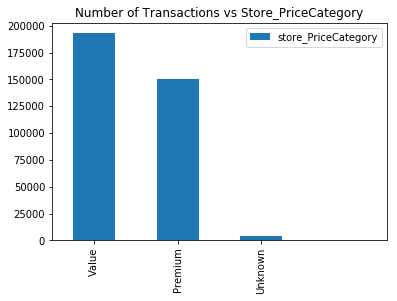

In [39]:
# Number of transactions vs store_price category
df['store_PriceCategory'].value_counts()
df['store_PriceCategory'].value_counts().reset_index().plot(kind='bar')
plt.xticks([0,1,2],df['store_PriceCategory'].value_counts().reset_index()['index'])
plt.title('Number of Transactions vs Store_PriceCategory')

In [40]:
#Extracting YearMonth from the billing_timestamp
df['Year_Month']=df['billing_timestamp'].map(lambda x : 100*x.year+x.month)

In [41]:
df['Year_Month'].unique()

array([201410, 201411, 201412, 201501, 201502, 201503, 201504, 201505,
       201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601,
       201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609,
       201610, 201611, 201612, 201701, 201702, 201703, 201704, 201705,
       201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801,
       201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809,
       201810, 201811, 201812, 201901, 201902, 201903, 201904, 201905,
       201906, 206206, 201907, 201908], dtype=int64)

In [42]:
#There is a year 2062 #We need to drop

df[df['Year_Month']==206206]

df=df[df['Year_Month']!=206206]

In [43]:
#Total Amount Transactioned from Oct 2014 to Aug 2019
x=df.groupby(['Year_Month'])['amount'].sum().reset_index()
x.head()

,Year_Month,amount
0,201410,55314202.07
1,201411,6361142.55
2,201412,8213137.07
3,201501,13376994.46
4,201502,5670653.93


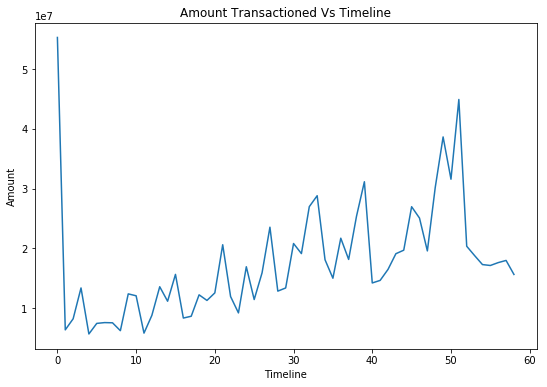

In [44]:
#plotting the amount transactoined vs timeline
plt.figure(figsize=(9,6))
plt.plot(x.index,x['amount'])
plt.xlabel('Timeline')
plt.ylabel('Amount')
plt.title('Amount Transactioned Vs Timeline')

plt.show()


*we can infer the increasing trend and occuring seasonality of the transactions.*

In [45]:
df['Year']=df['billing_timestamp'].map(lambda x : x.year)

df['Year'].value_counts()

2018    86479
2017    78122
2016    64108
2019    54705
2015    43049
2014    22045
Name: Year, dtype: int64

Text(0.5, 1.0, 'Amount Transactioned in different years')

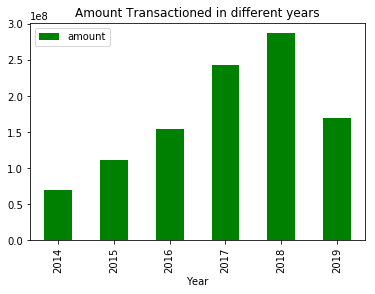

In [46]:
# Total amount transactioned in different years
df.groupby(['Year'])['amount'].sum().reset_index().plot('Year','amount',kind='bar',color='g')
plt.title('Amount Transactioned in different years')

### <font color='green'> Multivariate Analysis

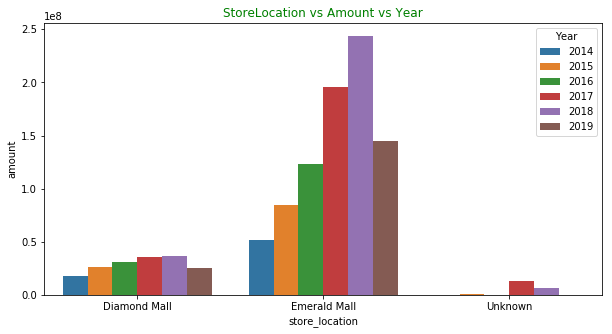

In [47]:
#StoreLocation vs Amount vs Year
c=df.groupby(['Year','store_location'])['amount'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.barplot('store_location',"amount",data=c,hue='Year')

plt.title("StoreLocation vs Amount vs Year",color='g')
plt.show()

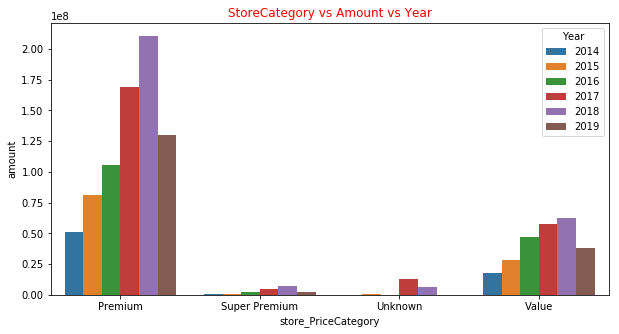

In [48]:
#StoreCategory vs Amount vs Year
a=df.groupby(['Year','store_PriceCategory'])['amount'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot('store_PriceCategory',"amount",data=a,hue='Year')
plt.title("StoreCategory vs Amount vs Year",color='r')
plt.show()

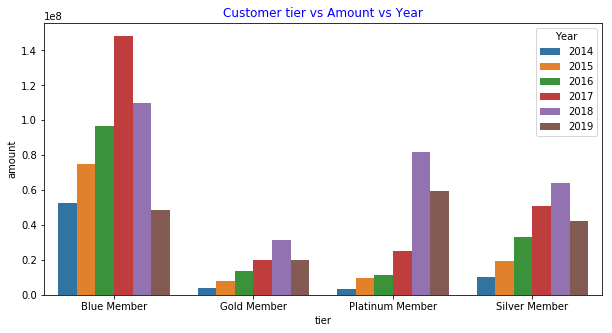

In [49]:
#Customer tier vs Amount vs Year
b=df.groupby(['Year','tier'])['amount'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot('tier',"amount",data=b,hue='Year')

plt.title("Customer tier vs Amount vs Year",color='b')
plt.show()

### <font color='green'> Top 10 customers- Analysis

In [50]:
#Grouping the customers
customer=df.groupby('customer_id').agg({'amount':sum,'points':sum,'tier':pd.Series.mode,
                                   'gender':pd.Series.mode,'state':pd.Series.mode}).reset_index()


n=customer.sort_values(by='amount',ascending=False)[:10].reset_index(drop=True)
n #Top 10 customers who have spent more

,customer_id,amount,points,tier,gender,state
0,249853390927,38313774.36,428942.76,Platinum Member,Male,Maharashtra
1,234549952039,11152508.10,116627.56,Platinum Member,Male,Maharashtra
2,255285716438,5607268.35,58584.73,Platinum Member,Female,Maharashtra
3,218685897215,5518171.00,65979.99,Blue Member,Female,Maharashtra
4,256626721286,4635650.25,48489.55,Platinum Member,Male,Maharashtra
5,201487636674,4416697.21,64146.93,Platinum Member,Male,Maharashtra
6,206429912326,4171951.00,50957.64,Blue Member,Female,Maharashtra
7,257909087121,3717029.00,42984.33,Blue Member,Female,Maharashtra
8,251349876513,3713864.00,39816.48,Platinum Member,Unknown,Maharashtra
9,260454328530,3453047.97,35105.72,Gold Member,Female,Maharashtra


In [51]:
# Malls purchased by the top customer
df[df['customer_id']=='249853390927']['store_location'].value_counts()

Emerald Mall    487
Diamond Mall      3
Name: store_location, dtype: int64

In [52]:
# Store cateogry purchased by the top customer
df[df['customer_id']=='249853390927']['store_PriceCategory'].value_counts()

Premium    464
Value       26
Name: store_PriceCategory, dtype: int64

In [53]:
#Percentage of contribution to the total sum
(df[df['customer_id'].isin(n['customer_id'])]['amount'].sum()/df['amount'].sum()) *100


8.166279942465557

In [54]:
df[df['customer_id'].isin(n['customer_id'])]['store_PriceCategory'].value_counts()

Premium          3194
Value             886
Super Premium      23
Unknown             2
Name: store_PriceCategory, dtype: int64

In [55]:
df[df['customer_id'].isin(n['customer_id'])]['store_category'].value_counts()

Electronics                                                                                                                                  878
Women's Fashion                                                                                                                              819
Beauty & Grooming                                                                                                                            336
Women's Fashion,Men's Fashion                                                                                                                336
Accessories,Women's Fashion,Men's Fashion                                                                                                    334
Food & Beverage                                                                                                                              274
Electronics,Kids Fashion,Accessories,Grocery & Household,Home & Lifestyle,Women's Fashion,Men's Fashion,Books and Stationery,Gifts

<ul>
<li>Customer with customer id "249853390927" is the top customer who made the transactions with total amount of 38559062 (Three Crores and eighty five lakhs fifty nine thousand sixty two) </li>
<li>This platinum member has made most of his transactions on Emerald Mall with premium stores</li>
<li>Top 10 customers made 4298 transactions in total</li>
<li>Top 10 customers contribute to 8.5% of total amount transactioned</li>
<li>Out of this 10 customers 4 are male and 5 are female</li>
<li>7 platinum members out of 10</li>
<li>Has made most of their transactions on premium store</li>
<li>Electronics contribute much on their amount transactioned</li>
<li>As there are five females ,Women's Fashion also contributed much in their amount transactioned.</li>
    </ul>

## RFM Analysis
RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary).

In [56]:
print("Date is spread between",df['billing_timestamp'].min(),"and",df['billing_timestamp'].max())

Date is spread between 2014-10-20 22:38:00+05:30 and 2019-08-29 15:43:00+05:30


### <font color='green'> Generating R,F and M

In [57]:

#Let's assume that the study is being done as of 01/Sep/2019.
#Number of days from the study date is calculated.
sd=dt.datetime(2019,9,1)

#Removing the time zone from the timestamp
df['billing_timestamp']=df['billing_timestamp'].dt.tz_localize(None)

rfm=df.groupby('customer_id').agg({'billing_timestamp': lambda x : (sd-x.max()).days,
                                   'customer_id':'count','amount':'sum'})

rfm.columns=['Recency','Frequency','Monetary']

In [58]:
rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
162074559143,62,1,1.0
162082081317,432,1,54419.0
163623918706,70,1,1078.8
164381930905,84,1,2473.5
182929244726,99,1,7995.0


In [59]:
rfm.describe()

,Recency,Frequency,Monetary
count,13177.000000,13177.000000,1.317700e+04
mean,614.852091,26.448205,7.871226e+04
std,564.720367,89.194342,4.234391e+05
min,2.000000,1.000000,1.000000e+00
25%,136.000000,1.000000,5.000000e+03
50%,376.000000,2.000000,8.897000e+03
75%,848.000000,12.000000,3.732000e+04
max,1776.000000,2541.000000,3.831377e+07


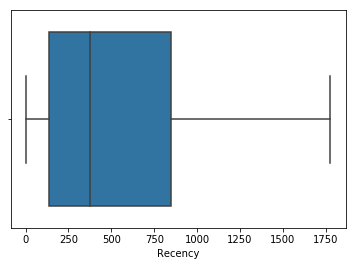

In [60]:
sns.boxplot(rfm['Recency'])
# We can infer that recency is distributed between 136 and 848 days in IQR

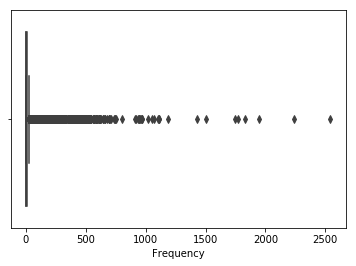

In [61]:
sns.boxplot(rfm['Frequency'])
#We can infer that there are more less frequent customers

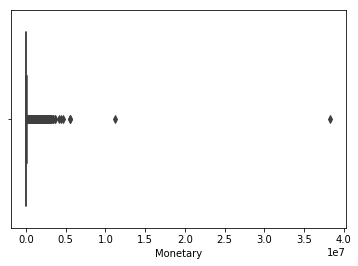

In [62]:
sns.boxplot(rfm['Monetary'])
#most of the customers spent less

### <font color='green'> Creating labels for R,F and M

In [63]:

#Creating Labels for Recency and Frequency
r_labels=range(4,0,-1) #More recent customers are more valued
f_labels=range(1,5)
#Assign these labels to four equal percentile groups
r_groups=pd.qcut(rfm['Recency'],4,labels=r_labels)


In [64]:
rfm['Frequency'].describe() #As the frequency is more biased it is more meaningful to cut using bins

count    13177.000000
mean        26.448205
std         89.194342
min          1.000000
25%          1.000000
50%          2.000000
75%         12.000000
max       2541.000000
Name: Frequency, dtype: float64

In [65]:
#Assigning groups to frequency
f_groups=pd.cut(rfm['Frequency'],bins=[0,2,12,100,2542],labels=f_labels)

In [66]:
rfm=rfm.assign(R=r_groups.values,F=f_groups.values)

rfm.head()

,Recency,Frequency,Monetary,R,F
customer_id,,,,,
162074559143,62,1,1.0,4,1
162082081317,432,1,54419.0,2,1
163623918706,70,1,1078.8,4,1
164381930905,84,1,2473.5,4,1
182929244726,99,1,7995.0,4,1


In [67]:
#Assigning groups to Monetary Vaues
m_labels=range(1,5)
m_groups=pd.qcut(rfm['Monetary'],4,labels=m_labels)

rfm=rfm.assign(M=m_groups.values)

rfm.head()

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
162074559143,62,1,1.0,4,1,1
162082081317,432,1,54419.0,2,1,4
163623918706,70,1,1078.8,4,1,1
164381930905,84,1,2473.5,4,1,1
182929244726,99,1,7995.0,4,1,2


In [68]:
#Concatenate R,F,M values to create RFM Segments
def join(x):
    return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM']=rfm.apply(join,axis=1)

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM
customer_id,,,,,,,
162074559143,62,1,1.0,4,1,1,411
162082081317,432,1,54419.0,2,1,4,214
163623918706,70,1,1078.8,4,1,1,411
164381930905,84,1,2473.5,4,1,1,411
182929244726,99,1,7995.0,4,1,2,412


In [69]:
rfm['RFM'].nunique()

52

In [70]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score
customer_id,,,,,,,,
162074559143,62,1,1.0,4,1,1,411,6.0
162082081317,432,1,54419.0,2,1,4,214,7.0
163623918706,70,1,1078.8,4,1,1,411,6.0
164381930905,84,1,2473.5,4,1,1,411,6.0
182929244726,99,1,7995.0,4,1,2,412,7.0


### <font color='green'> Define RFM level function <br>

We can get creative and hypothesize about what each score range entails

In [71]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 8:
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score,RFM_Level
customer_id,,,,,,,,,
162074559143,62,1,1.0,4,1,1,411,6.0,Potential
162082081317,432,1,54419.0,2,1,4,214,7.0,Loyal
163623918706,70,1,1078.8,4,1,1,411,6.0,Potential
164381930905,84,1,2473.5,4,1,1,411,6.0,Potential
182929244726,99,1,7995.0,4,1,2,412,7.0,Loyal


In [72]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm.groupby('RFM_Level').agg({
    'Recency': ['mean'],
    'Frequency': ['mean'],
    'Monetary': ['mean'],
    'RFM_Level':'count'
}).sort_values(by=('Monetary','mean'),ascending=False)

,Recency,Frequency,Monetary,RFM_Level
,mean,mean,mean,count
RFM_Level,,,,
Champions,254.654759,76.561692,224177.641450,4255
Loyal,563.821599,5.522215,22447.029310,1463
Potential,607.135738,2.751952,9516.505348,2689
Promising,803.507614,1.851664,6365.161732,1773
Needs Attention,948.326716,1.330438,4987.101456,2418
Require Activation,1456.335060,1.310881,2662.354888,579


### <font color='green'> Final Inference from the RFM labels
**Champions** : <br>
Highly engaged customers who have bought the most recent, the most often, and generated the most revenue. <br>
Marketing Strategies: Focus on loyalty programs and new product introductions. These customers have proven to have a higher willingness to pay, so don't use discount pricing to generate incremental sales. Instead, focus on value added offers through product recommendations based on previous purchases.<br> <br>
**Loyal** : <br>
These customers have demonstrated a high willingness to pay. Consider premium offers, subscription tiers, luxury products, or value add cross/up-sells to increase AOV. Don't waste margin on discounts.  <br> <br>

**Potential** : <br>
 Loyalty programs are effective for repeat visitors. Advocacy programs and reviews are also common strategies. Lastly, consider rewarding these customers with Free Shipping or other like benefits. <br> <br>
 
 **Promising** : <br>
 Focus on increasing monetization through product recommendations based on past purchases and incentives tied to spending thresholds . <br><br>
 **Needs attention**: <br>
 Once Loyal, Now Gone. Customers leave for a variety of reasons. Depending on your situation price deals, new product launches, or other retention strategies.<br><br>
 
 **Requires Activation** : <br>
 Gone for a long time also the high risk customers. Requires activation by specific marketing strategies as if like a new customer.


## <font color= red> Clustering

*K-means clustering is a very simple and fast algorithm and can efficiently deal with very large data sets.*

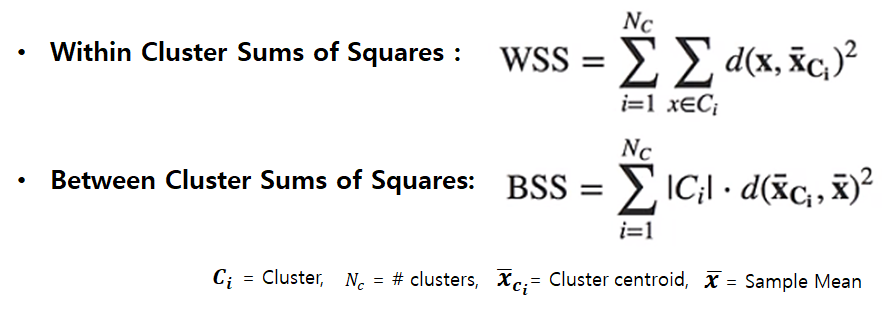

In [73]:
#Clustering

Image(filename='cluster.png') 

### <font color='green'> Pre-processing for clustering

In [74]:
rfm_c=rfm[['Recency','Frequency','Monetary']]

rfm_c.head()

,Recency,Frequency,Monetary
customer_id,,,
162074559143,62,1,1.0
162082081317,432,1,54419.0
163623918706,70,1,1078.8
164381930905,84,1,2473.5
182929244726,99,1,7995.0


In [75]:
#Scaling the data to apply k-means clustering
#applying log to the skewed data.
def neg_to_zero(x): #Neglecting zeros to take log
    if x<=0:
        return 1
    else:
        return x
rfm['Recency'] = [neg_to_zero(x) for x in rfm.Recency]
rfm['Monetary'] = [neg_to_zero(x) for x in rfm.Monetary]

rfm_log=rfm_c.apply(np.log , axis=1).round(3)

#To scale the data
scaler=preprocessing.StandardScaler()
rfm_scaled=scaler.fit_transform(rfm_log)

# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)

In [76]:
rfm_scaled.head()

,Recency,Frequency,Monetary
customer_id,,,
162074559143,-1.152703,-0.865279,-5.480765
162082081317,0.218754,-0.865279,0.815757
163623918706,-1.067207,-0.865279,-1.447850
164381930905,-0.937905,-0.865279,-0.969143
182929244726,-0.822027,-0.865279,-0.291216


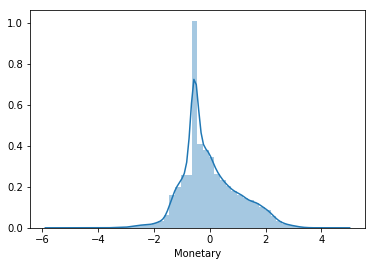

In [77]:
sns.distplot(rfm_scaled['Monetary'])

### <font color='green'> Elbow method 
    > To choose optimum numnber of clusters

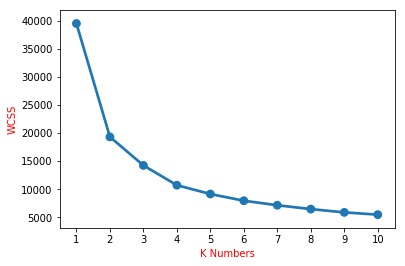

In [78]:
#The elbow method to choose the number of clusters

wss={}
for k in range(1,11):
    kmeans=KMeans(n_clusters=k,init='k-means++', max_iter=300)
    kmeans.fit(rfm_scaled)
    wss[k]=kmeans.inertia_
#plot the wss values
sns.pointplot(x = list(wss.keys()), y = list(wss.values()))
plt.xlabel('K Numbers',color='r')
plt.ylabel('WCSS',color='r')
plt.show()

We observe that value of kmeans inertia decreases by small amounts after iteration no. 4 suggesting that the algorithm has almost converged.

In [79]:
rfm_cluster=rfm_scaled.copy()
rfm_cluster.head()

,Recency,Frequency,Monetary
customer_id,,,
162074559143,-1.152703,-0.865279,-5.480765
162082081317,0.218754,-0.865279,0.815757
163623918706,-1.067207,-0.865279,-1.447850
164381930905,-0.937905,-0.865279,-0.969143
182929244726,-0.822027,-0.865279,-0.291216


In [80]:
#Choosing the optimum number of cluster to be 4
# clustering
clus = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 300)
clus.fit(rfm_cluster)# Assign the clusters to datamart
rfm_cluster['K_Cluster'] = clus.labels_
rfm_cluster.head()


,Recency,Frequency,Monetary,K_Cluster
customer_id,,,,
162074559143,-1.152703,-0.865279,-5.480765,2
162082081317,0.218754,-0.865279,0.815757,0
163623918706,-1.067207,-0.865279,-1.447850,2
164381930905,-0.937905,-0.865279,-0.969143,2
182929244726,-0.822027,-0.865279,-0.291216,2


In [81]:
#plotting cluster
def plot_cluster (data):
    fig,axs = plt.subplots(3,1,figsize=(10,15))
    color = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]
    c=sns.color_palette(color)
    sns.scatterplot(data['Recency'],data['Monetary'],hue=data['K_Cluster'],
                    palette=c,ax=axs[0])
    axs[0].title.set_text('Recency vs Monetary')
    axs[0].get_legend().remove()
    sns.scatterplot(data['Recency'],data['Frequency'],hue=data['K_Cluster'],
                    palette=c,ax=axs[1])
    axs[1].title.set_text('Recency vs Frequency')
    axs[1].get_legend().remove()
    sns.scatterplot(data['Monetary'],data['Frequency'],hue=data['K_Cluster'],
                    palette=c,ax=axs[2])
    axs[2].title.set_text('Monetary vs Frequency')
    axs[2].get_legend().remove()
    handles,labels=plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels,loc='upper center')
    plt.show()

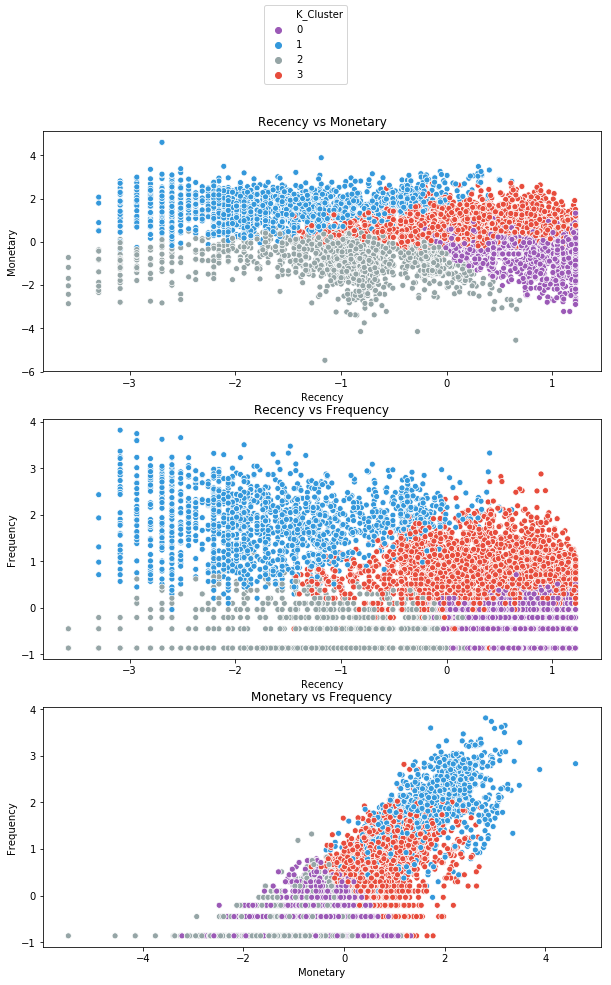

In [82]:
plot_cluster(rfm_cluster) #4 clusters

### <font color='green'> Silhouette coefficient
    Silhouette Coefficient or silhouette score is a metric used to calculate the
    goodness of a clustering technique. Its value ranges from -1 to 1.

In [84]:
from sklearn.metrics import silhouette_score
silhouette_score(rfm_scaled,clus.labels_)

0.37361457400667425

### Inference from clusters
**Cluster 0 :Requires Activation**  <br>
 Gone for a long time also the high risk customers. Requires activation by specific marketing strategies as if like a new customer.<br> <br>
 **Cluster 1 :Champions** : <br>
Highly engaged customers who have bought the most recent, the most often, and generated the most revenue. <br>
Marketing Strategies: Focus on loyalty programs and new product introductions. These customers have proven to have a higher willingness to pay, so don't use discount pricing to generate incremental sales. Instead, focus on value added offers through product recommendations based on previous purchases.<br> <br>
**Cluster 2 :Potential** : <br>
 Loyalty programs are effective for repeat visitors. Advocacy programs and reviews are also common strategies. Lastly, consider rewarding these customers with Free Shipping or other like benefits. <br> <br>
  **Cluster 3 : Promising** : <br>
 Focus on increasing monetization through product recommendations based on past purchases and incentives tied to spending thresholds . <br><br>